In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from scipy.stats import norm, multivariate_normal
from tqdm import tqdm
plt.rcParams.update({'font.size': 12})

In [14]:
def generate_dataset(params, fixed_mu=False):
    """
    Generate a dataset with the given parameters.
    Args:
        params: a dictionary containing the parameters of the dataset
        fixed_mu: if True, the mean vector is fixed to be [1/sqrt(d), ..., 1/sqrt(d)]
    Returns:
        X_pos: a numpy array of shape (n_pos, d) containing the positive examples
        X_neg: a numpy array of shape (n_neg, d) containing the negative examples
    """
    mu_norm, sigma, n, p, d = params['mu_norm'], params['sigma'], params['n'], params['p'], params['d']
    # Generate the mean vector and covariance matrix
    mu = np.ones(d) * mu_norm / np.sqrt(d) if fixed_mu else generate_random_mu(d, mu_norm)
    cov = np.eye(d) * sigma
    # Generate the number of positive, negative, and minority examples
    n_pos, n_maj, n_min = np.random.multinomial(n, (1/2, p/2, (1-p)/2))
    X_pos, X_maj, X_min = generate_multivariate_normals(mu, cov, n_pos, n_maj, n_min)
    X_neg = np.concatenate((X_maj, X_min))
    return X_pos, X_neg


def generate_random_mu(d, mu_norm):
    """Generate a random mean vector with norm mu_norm."""
    mu = np.random.normal(0, 1, d)
    mu = mu / np.linalg.norm(mu)
    return mu * mu_norm


def generate_multivariate_normals(mu, cov, n_pos, n_maj, n_min):
    """Generate multivariate normal samples with the given parameters."""
    X_pos = np.random.multivariate_normal(mu, cov, n_pos)
    X_maj = np.random.multivariate_normal(-mu, cov, n_maj)
    X_min = np.random.multivariate_normal(3 * mu, cov, n_min)
    return X_pos, X_maj, X_min


def phi(x):
    return norm.cdf(x)


def lda_err_bound(mu_norm, sigma, p):
    """Compute the error bound of LDA."""
    s1 = phi(-(2 * p - 1) * mu_norm / sigma)
    s2 = p * phi(-(3 - 2 * p) * mu_norm / sigma)
    s3 = (1 - p) * phi((2 * p + 1) * mu_norm / sigma)
    return (s1 + s2 + s3) / 2


def mda_err_bound(mu_norm, sigma, p):
    """Compute the error bound of MDA."""
    s1 = phi(-mu_norm / sigma + sigma * np.log(p) / 2 / mu_norm)
    s2 = phi(-mu_norm / sigma + sigma * np.log(1 - p) / 2 / mu_norm)
    s3 = p * phi(-mu_norm / sigma - sigma * np.log(p) / 2 / mu_norm)
    s4 = (1 - p) * phi(-mu_norm / sigma - sigma * np.log(1 - p) / mu_norm)
    return (s1 + s2 + s3 + s4) / 2


def fit_and_evaluate_lda(X_train, y_train, X_test, y_test):
    """Fit LDA on the training data and evaluate the error rate on the test data."""
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred_lda = lda.predict(X_test)
    lda_error_rate = 1 - accuracy_score(y_test, y_pred_lda)
    return lda_error_rate


def multivariate_normal_pdfs(X, mu, cov):
    """Compute the pdfs of the multivariate normal distributions with the given parameters."""
    f_1 = multivariate_normal.pdf(X, mu, cov)
    f_m1 = multivariate_normal.pdf(X, -mu, cov)
    f_3m = multivariate_normal.pdf(X, 3 * mu, cov)
    return f_1, f_m1, f_3m


def mda_predict(X, mu, sigma, p):
    """Predict the labels of the test data using MDA."""
    cov = sigma * np.eye(mu.shape[0])
    f_1, f_m1, f_3m = multivariate_normal_pdfs(X, mu, cov)
    preds = [1 if 0.5 * fx_1 >= p / 2 * fx_m1 and 0.5 * fx_1 >= (1 - p) / 2 * fx_3m else 0
             for fx_1, fx_m1, fx_3m in zip(f_1, f_m1, f_3m)]
    preds = np.array(preds)
    return preds


def fit_and_evaluate_mda(X_train, y_train, X_test, y_test, params):
    """Fit MDA on the training data and evaluate the error rate on the test data."""
    mu = np.mean(X_train[y_train == 1], axis=0)
    y_pred_mda = mda_predict(X_test, mu, params['sigma'], params['p'])
    mda_error_rate = 1 - accuracy_score(y_test, y_pred_mda)
    return mda_error_rate


def experiment(params, iters):
    """Run the experiment for the given parameters and number of iterations."""
    lda_error_rates, mda_error_rates = [], []
    for _ in range(iters):
        X_pos, X_neg = generate_dataset(params)
        X_train, y_train, X_test, y_test = split_data(X_pos, X_neg)
        lda_error_rates.append(fit_and_evaluate_lda(X_train, y_train, X_test, y_test))
        mda_error_rates.append(fit_and_evaluate_mda(X_train, y_train, X_test, y_test, params))
    return lda_error_rates, mda_error_rates


def split_data(X_pos, X_neg):
    """Split the data into training and test sets."""
    X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
        X_pos, np.ones(X_pos.shape[0]), test_size=0.3
    )
    X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(
        X_neg, np.zeros(X_neg.shape[0]), test_size=0.3
    )
    X_train = np.concatenate((X_train_pos, X_train_neg))
    y_train = np.concatenate((y_train_pos, y_train_neg))
    X_test = np.concatenate((X_test_pos, X_test_neg))
    y_test = np.concatenate((y_test_pos, y_test_neg))
    return X_train, y_train, X_test, y_test


def experiment_p_and_q(params, iters, q):
    """Run the experiment training on p and testing on q."""
    lda_error_rates, mda_error_rates = [], []
    for _ in range(iters):
        # Generate the training data with p taken from params dictionary and fixed mu
        X_train_pos, X_train_neg = generate_dataset(params, fixed_mu=True)
        y_train_pos, y_train_neg = np.ones(X_train_pos.shape[0]), np.zeros(X_train_neg.shape[0])
        # Generate the test data with p=q and fixed mu
        params['p'] = q
        X_test_pos, X_test_neg = generate_dataset(params, fixed_mu=True)
        y_test_pos, y_test_neg = np.ones(X_test_pos.shape[0]), np.zeros(X_test_neg.shape[0])

        X_train = np.concatenate((X_train_pos, X_train_neg))
        y_train = np.concatenate((y_train_pos, y_train_neg))
        X_test = np.concatenate((X_test_pos, X_test_neg))
        y_test = np.concatenate((y_test_pos, y_test_neg))
        # Fit and evaluate the models
        lda_error_rates.append(fit_and_evaluate_lda(X_train, y_train, X_test, y_test))
        mda_error_rates.append(fit_and_evaluate_mda(X_train, y_train, X_test, y_test, params))

    return lda_error_rates, mda_error_rates


def experiments_over_parameter(param_name, interval, iters):
    """Run the experiments varying the given parameter over the given interval iters times."""
    # Set the default parameters
    params = {'mu_norm': 2, 'sigma': 1, 'n': 10000, 'p': 0.9, 'd': 50}
    results = []
    for param in tqdm(interval):
        params[param_name] = param # Set the parameter to the current value
        mu_norm, sigma, p, n, d = params['mu_norm'], params['sigma'], params['p'], params['n'], params['d']
        lda_error_rates, mda_error_rates = experiment(params, iters)
        
        lda_bound, mda_bound = lda_err_bound(mu_norm, sigma, p), mda_err_bound(mu_norm, sigma, p)
        results.append((
            np.mean(lda_error_rates), np.mean(mda_error_rates),
            np.std(lda_error_rates) / np.sqrt(iters), np.std(mda_error_rates) / np.sqrt(iters),
            lda_bound, mda_bound,
            np.mean(np.abs(lda_error_rates - lda_bound) * np.sqrt(n / d / np.log(n))),
            np.mean(np.abs(mda_error_rates - mda_bound) * np.sqrt(n / d / np.log(n))),
            np.std(np.abs(lda_error_rates - lda_bound) * np.sqrt(n / d / np.log(n))) / np.sqrt(iters),
            np.std(np.abs(mda_error_rates - mda_bound) * np.sqrt(n / d / np.log(n))) / np.sqrt(iters)
        ))

    return zip(*results)


def experiments_over_p_and_q(q, ts, iters):
    """Run the experiments training on 1 - 1 / ts and testing on q."""
    # Set the default parameters
    params = {'mu_norm': 2, 'sigma': 1, 'n': 10000, 'p': 0.9, 'd': 50}
    results = []
    for t in tqdm(ts):
        params['p'] = 1 - 1 / t # Set p to the current value
        lda_error_rates, mda_error_rates = experiment_p_and_q(params, iters, q)
        results.append((
            np.mean(lda_error_rates), np.mean(mda_error_rates),
            np.std(lda_error_rates), np.std(mda_error_rates)
        ))

    return zip(*results)


def plot_results(interval, results, param_name, differences=False, sep=False):
    """
    Plot the results of the experiments.
    Args:
        interval: the interval over which the parameter was varied.
        results: the results of the experiments.
        param_name: the name of the parameter that was varied.
        differences: whether to plot the differences between the error rates and the bounds.
        sep: whether to plot the error rates and the bounds for LDA and MDA separately.
    """
    lda_errors_mean, mda_errors_mean, lda_errors_std, mda_errors_std, lda_bounds, mda_bounds, \
    lda_diffs_mean, mda_diffs_mean, lda_diffs_std, mda_diffs_std = results

    if differences:
        plot_differences(interval, lda_diffs_mean, mda_diffs_mean, lda_diffs_std, mda_diffs_std, param_name)
    else:
        plot_errors(interval, lda_errors_mean, mda_errors_mean, lda_errors_std, mda_errors_std,
                    lda_bounds, mda_bounds, param_name, sep)


def plot_differences(interval, lda_diffs_mean, mda_diffs_mean, lda_diffs_std, mda_diffs_std, param_name):
    """Plot the differences between the error rates and the bounds."""
    plt.plot(interval, lda_diffs_mean, label='LDA', color='#1f77b4')
    plt.fill_between(interval,
                     np.array(lda_diffs_mean) - 1.96 * np.array(lda_diffs_std),
                     np.array(lda_diffs_mean) + 1.96 * np.array(lda_diffs_std),
                     alpha=0.2, color='#1f77b4')
    plt.plot(interval, mda_diffs_mean, label='MDA', color='#ff7f0e')
    plt.fill_between(interval,
                     np.array(mda_diffs_mean) - 1.96 * np.array(mda_diffs_std),
                     np.array(mda_diffs_mean) + 1.96 * np.array(mda_diffs_std),
                     alpha=0.2, color='#ff7f0e')
    plt.xlabel(xlabels[param_name])
    plt.ylabel('Difference')
    plt.legend()
    plt.savefig('figs/difference.png', dpi=300, bbox_inches='tight')


def plot_errors(interval,
                lda_errors_mean,
                mda_errors_mean,
                lda_errors_std,
                mda_errors_std,
                lda_bounds,
                mda_bounds,
                param_name,
                sep):
    """Plot the error rates and the bounds."""
    plt.xlabel(xlabels[param_name])
    plt.ylabel('Error')
    plt.plot(interval, lda_errors_mean, label='LDA Error', color='#1f77b4')
    plt.fill_between(interval,
                     np.array(lda_errors_mean) - 1.96 * np.array(lda_errors_std),
                     np.array(lda_errors_mean) + 1.96 * np.array(lda_errors_std),
                     alpha=0.2, color='#1f77b4')
    plt.plot(interval, lda_bounds, label='LDA Error bound (10)', color='#1f77b4', linestyle='--')
    if sep:
        plt.legend()
        plt.savefig(f'figs/lda_{param_name}.png', bbox_inches='tight', dpi=300)
        plt.show()
        plt.clf()
    plt.xlabel(xlabels[param_name])
    plt.ylabel('Error')
    plt.plot(interval, mda_errors_mean, label='MDA Error', color='#ff7f0e')
    plt.fill_between(interval,
                     np.array(mda_errors_mean) - 1.96 * np.array(mda_errors_std),
                     np.array(mda_errors_mean) + 1.96 * np.array(mda_errors_std),
                     alpha=0.2, color='#ff7f0e')
    plt.plot(interval, mda_bounds, label='MDA Error bound (13)', color='#ff7f0e', linestyle='--')
    if sep:
        plt.legend()
        plt.savefig(f'figs/mda_{param_name}.png', bbox_inches='tight', dpi=300)
        plt.show()
    else:
        plt.legend()
        plt.savefig(f'figs/lda_mda_{param_name}.png', dpi=300, bbox_inches='tight')
        plt.show()


def plot_results_p_and_q(ts, results, mda_only=False, logscale=False):
    """Plot the results of the experiments on training on p and testing on q."""
    lda_errors_mean, mda_errors_mean, lda_errors_std, mda_errors_std = results

    if not mda_only:
        plt.plot(ts, lda_errors_mean, label='LDA Error', color='#1f77b4')
        plt.fill_between(ts,
                         np.array(lda_errors_mean) - 1.96 * np.array(lda_errors_std),
                        np.array(lda_errors_mean) + 1.96 * np.array(lda_errors_std),
                        alpha=0.2, color='#1f77b4')
    plt.plot(ts, mda_errors_mean, label='MDA Error', color='#ff7f0e')
    plt.fill_between(ts,
                     np.array(mda_errors_mean) - 1.96 * np.array(mda_errors_std),
                     np.array(mda_errors_mean) + 1.96 * np.array(mda_errors_std),
                     alpha=0.2, color='#ff7f0e')
    plt.legend()
    if logscale:
        plt.xscale('log')
    plt.xlabel("$t$")
    plt.ylabel('Error')
    plt.savefig(f'figs/p_q.png', bbox_inches='tight', dpi=300)
    plt.show()


# Maps parameter names to their LaTeX representations.
xlabels = {
    'mu_norm': '$\\|\\mu\\|$',
    'sigma': '$\\sigma$',
    'p': '$p$',
    'n': '$n$',
    'd': '$d$',
}

100%|██████████| 50/50 [00:53<00:00,  1.08s/it]


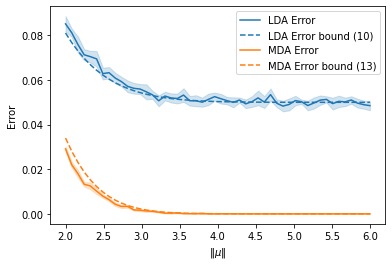

In [30]:
np.random.seed(69) # set seed

# Vary the nu_norm, keeping the other parameters fixed
mu_norms = np.linspace(2, 6, 50)
results = experiments_over_parameter('mu_norm', mu_norms, 10)
plot_results(mu_norms, results, param_name='mu_norm')

100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


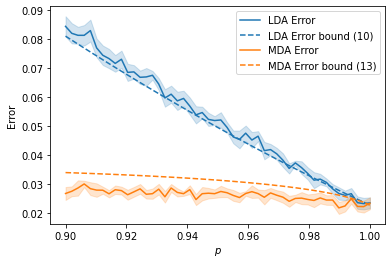

In [31]:
# Vary the p, keeping the other parameters fixed
ps = np.linspace(0.9, 1 - 1e-6, 50)
results = experiments_over_parameter('p', ps, 10)
plot_results(ps, results, param_name='p')

100%|██████████| 50/50 [00:59<00:00,  1.20s/it]


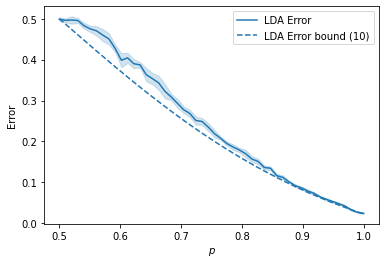

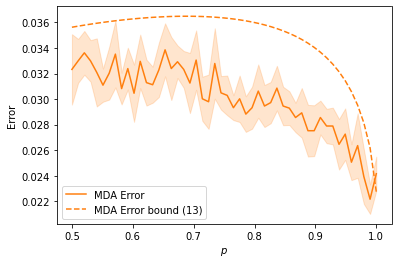

In [39]:
# Vary the p, keeping the other parameters fixed
ps = np.linspace(0.5, 1 - 1e-6, 50)
results = experiments_over_parameter('p', ps, 10)
# Plot the results separately for LDA and MDA
plot_results(ps, results, param_name='p', sep=True)

100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


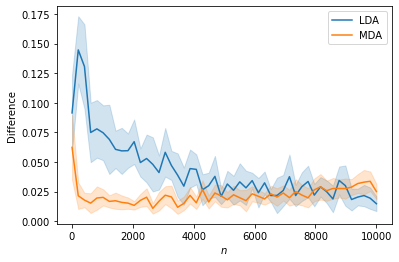

In [34]:
# Vary the n, keeping the other parameters fixed
ns = np.linspace(10, 10000, 50)
results = experiments_over_parameter('n', ns, 10)
plot_results(ns, results, param_name='n', differences=True)

100%|██████████| 50/50 [03:34<00:00,  4.29s/it]


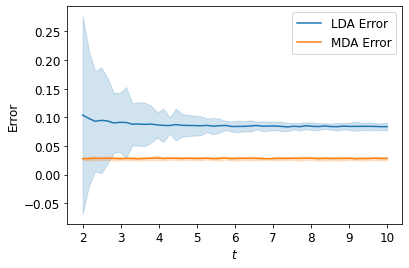

In [17]:
# Vary the p (which is 1 - 1/t), keeping the other parameters fixed
ts = np.linspace(2, 10, 50)
results = experiments_over_p_and_q(0.9, ts, 20)
plot_results_p_and_q(ts, results, mda_only=False)